# Q1：Donald Trump and Hillary Tweets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import sklearn as sklearn
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

# 1. Import data 

In [2]:
%cd /Users/Allen/Documents/ST4240/dataset
data = pd.read_csv("tweets.csv",encoding='latin-1')

/Users/Allen/Documents/ST4240/dataset


In [3]:
#Drop column and name change
data = data[['handle','text','time']]
data = data.rename(columns={"handle":"label"})

from sklearn.preprocessing import LabelEncoder
le = sklearn.preprocessing.LabelEncoder()
le.fit(data["label"])
data["label"] = le.transform(data["label"])    #change the labels to 0 and 1 

remove “realDonaldTrump” and “HillaryClinton” from the texts

In [4]:
text = list(map(lambda x : x.replace('realDonaldTrump', ''),data.text))
text = list(map(lambda x : x.replace('HillaryClinton', ''),text))

In [5]:
data = data.drop(["text"],axis = 1)
data = data.assign(text = text)

# 2. Create training and testing set

In [6]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(data, test_size = 0.3, random_state = 42,
                                               shuffle=True, stratify= data["label"] )   #select balanced sample
X_train = train[["text","time"]]
X_test = test[["text","time"]]
y_train = train["label"]
y_test = test["label"]
#Separate the training set to "ham" and "spam" 
train_hillary = train.loc[train.label == 0]
train_trump = train.loc[train.label == 1]

# 3. Examine words in two categories 
After converting all words to lower case, we use the RegexpTokenizer from nltk to tokenize words and remove all punctuations. 
After tokenising the words, we use WordNetLemmatizer as the stemming method to convert the words to their lemma and combine similar wordings. 
Lastly, we remove stopwords and natural numbers and create a list with all the remaining words. 

In [7]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
tokenizer = RegexpTokenizer(r'\w+') #tokenize words while removing punctuations
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() #to combine words of same lemma 

In [8]:
hillaryword = []
for i in train_hillary.text:
    words = i.lower()
    words = tokenizer.tokenize(words)
    for j in words:
        if j not in stopwords.words("english"):
            if not j.isdigit():
                j = lemmatizer.lemmatize(j)
                hillaryword.append(j)
            
trumpword = []
for i in train_trump.text:
    words = i.lower()
    words = tokenizer.tokenize(words)
    for j in words:
        if j not in stopwords.words("english"):
            if not j.isdigit():
                j = lemmatizer.lemmatize(j)
                trumpword.append(j)      

Examine the top 10 words occurring in both "Spam" and "ham" messages in Xtrain

In [9]:
from collections import Counter
hillarywordcount = Counter(hillaryword)
hillarywordcount.most_common(20)

[('co', 1743),
 ('http', 1741),
 ('â', 1048),
 ('trump', 638),
 ('hillary', 511),
 ('donald', 301),
 ('president', 194),
 ('american', 157),
 ('make', 143),
 ('america', 141),
 ('family', 140),
 ('u', 136),
 ('people', 132),
 ('woman', 130),
 ('one', 128),
 ('let', 110),
 ('potus', 105),
 ('need', 98),
 ('country', 94),
 ('right', 93)]

In [10]:
trumpwordcount = Counter(hillaryword)
trumpwordcount.most_common(20)

[('co', 1743),
 ('http', 1741),
 ('â', 1048),
 ('trump', 638),
 ('hillary', 511),
 ('donald', 301),
 ('president', 194),
 ('american', 157),
 ('make', 143),
 ('america', 141),
 ('family', 140),
 ('u', 136),
 ('people', 132),
 ('woman', 130),
 ('one', 128),
 ('let', 110),
 ('potus', 105),
 ('need', 98),
 ('country', 94),
 ('right', 93)]

We observe common words like "donald","trump","hillary","clinton","co","http", we now try to remove these words and draw a word cloud

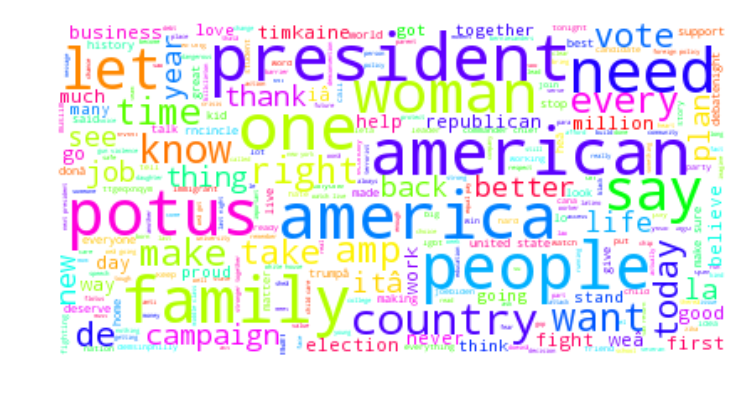

In [28]:
from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS
stopwords = set(STOPWORDS)
stopwords.add("donald")
stopwords.add("trump")
stopwords.add("hillary")
stopwords.add("clinton")
stopwords.add("co")
stopwords.add("http")

wc = WordCloud(background_color="white", max_words=2000, 
               stopwords=stopwords, max_font_size=40, random_state=42)
# generate word cloud
wc.generate(','.join(hillaryword))
import matplotlib.pyplot as plt
plt.imshow(wc)
plt.axis("off")
plt.show()

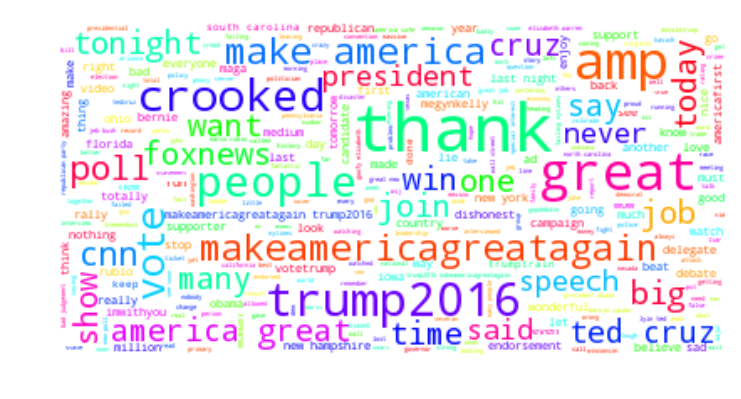

In [29]:
wc.generate(','.join(trumpword))
plt.imshow(wc)
plt.axis("off")
plt.show()

# 4. Vectorizing Xtrain and Xtest 
To prepare the training data for model building, we use vectorizer from sklearn.feature_extraction to convert Xtrain and Xtest to Compressed Sparse matrix.
We use TfidfVectorizer with stopword, select"idf"=True to reduce the weights of frequently occurred words, so that they will have less impact in the model.

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english',lowercase=True,use_idf=True)

In [30]:
Xtrain = vectorizer.fit_transform(X_train["text"])
Xtest = vectorizer.transform(X_test["text"]) #use the fitted vectorizer to transform X_test 
print(Xtrain.shape,Xtest.shape)

(4510, 10484) (1934, 10484)


# 5. Model Building 
##  5.1 Benchmark model: Multinomial Naivebayes 
For our benchmark model we build a Multinomail naivebayes model and examine the performance metrics.

Side note: From Sklearn documentation, we learnt that BernoulliNaiveBayes is also useful with short documents and binary features. 
By choosing ("binary" = True) and ("use_idf"=False) in TfidfVectorizer, we managed to obtain the transformed data 
as occurrence(0 or 1) instead of count. The prediction result is similar to MultinomialNB, and hence we stick to
MultinomialNB to allow for easier comparisons among models.

In [31]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,auc

In [32]:
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB()
NB.fit(Xtrain,y_train)
NB_pred = NB.predict(Xtest)
NB_pred_proba = NB.predict_proba(Xtest)

In [33]:
print ("prediciton Accuracy : %f" % accuracy_score(y_test, NB_pred))

prediciton Accuracy : 0.906412


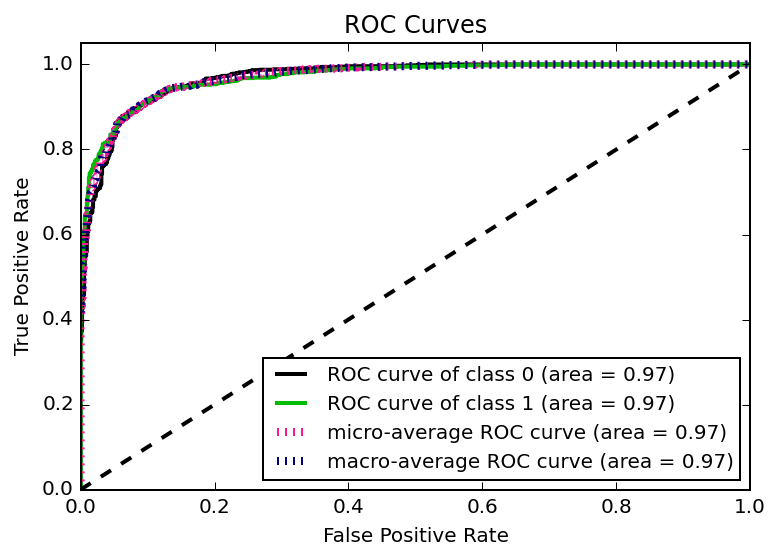

AUC Score : 0.969550


In [34]:
#Plot the ROC curve to examine the performance of the model 
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_roc_curve(y_test, NB_pred_proba)
plt.show()
print ("AUC Score : %f" % sklearn.metrics.roc_auc_score(y_test, NB_pred_proba[:,1]))

While both prediction accuracy(0.968301) and ROC curve(AUC=0.987751) suggest that the model performs very well in classifying the two messages, we continue to examine the confusion matrix and classification report to analyse the results closely. 
To visualize these two reports we use two function online. (see reference)

Confusion matrix, without normalization
[[883  85]
 [ 96 870]]


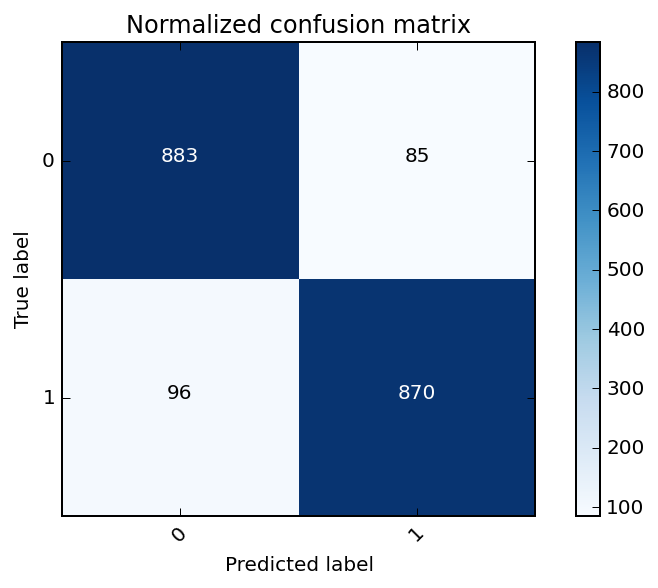

In [35]:
#Confusion Matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test,NB_pred), classes=['0', '1'], normalize=False,
                      title='Normalized confusion matrix')
plt.show()

In [36]:
#Classification table
def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.Blues):
    lines = cr.split('\n')
    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 3)]:
        t = line.split()
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        print(v)
        plotMat.append(v)
    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)
    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')
print(classification_report(y_test, NB_pred, labels=['0', '1']))

             precision    recall  f1-score   support

          0       0.90      0.91      0.91       968
          1       0.91      0.90      0.91       966

avg / total       0.91      0.91      0.91      1934



[0.9, 0.91, 0.91]
[0.91, 0.9, 0.91]


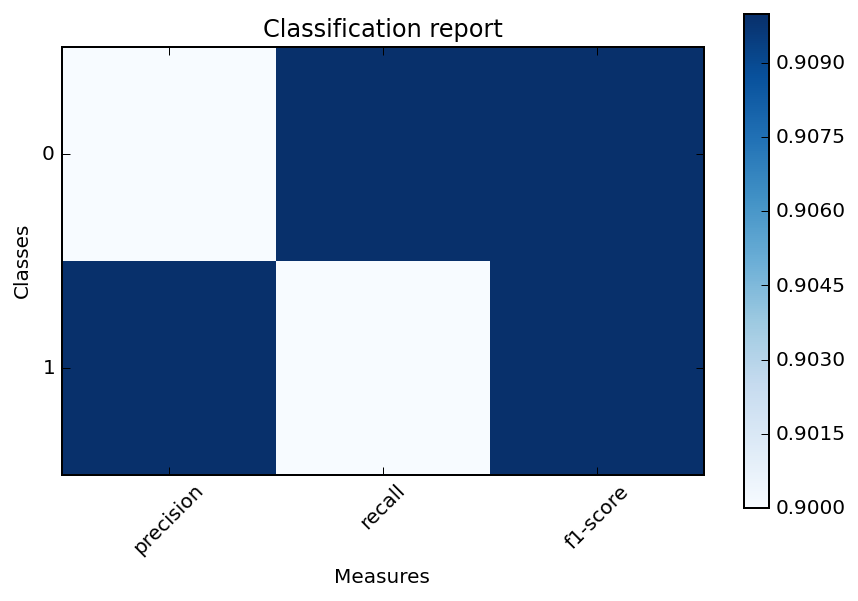

In [37]:
plot_classification_report(classification_report(y_test, NB_pred, labels=['0', '1']))

In [43]:
#class ratio:
print("hilary vs trump =",Counter(y_train)[0]/Counter(y_train)[1])

hilary vs trump = 1.002664298401421


- From the confusion matrix, we see that all "ham" messages are correctly classfied while only 77% of the "spam" messages are correctly classified. The low accuracy of predicting "spam" is not reflected in the accuracy metric and ROC curve. 

- From the classification report, we can tell that the precision of spam is perfect. However, we observe imbalance in the dataset as there are much more "ham" messages than "spam" messages. Therefore the low prediciton accuracy of "spam" messages is mitigated. 

- Therefore, during model training, we should adjust the weights of the two categories. 
We now try to use different models to look for improvement of result. 

In [39]:
#define a function for performance metrics
def model_eval(model,Xtrain,y_train, Xtest,y_test):
    pred = model.predict(Xtest)
    print ("Cross Validation score : ")
    print (cross_val_score(model, Xtrain, y_train, cv=5).mean())
    if not str(model)[:3] == "SGD":
        pred_proba = model.predict_proba(Xtest)
        pred_proba_c1 = pred_proba[:,1]
        print ("AUC Score : %f" % sklearn.metrics.roc_auc_score(y_test, pred_proba_c1))
    print ("prediciton Accuracy : %f" % accuracy_score(y_test, pred))
    print ("Confusion_matrix : ")
    print (confusion_matrix(y_test,pred))
    print ("classification report : ")
    print (classification_report(y_test, pred, labels=['0', '1']))

## 5.2 Logistic regression (with Cross Validation)

In [44]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegressionCV
#"liblinear" is suitable for small dataset, use L1(Lasso) regularization to reduce dimensions, adjust weights
LRcv = LogisticRegressionCV(solver="liblinear",penalty = "l1",class_weight ="balanced")  
LRcv.fit(Xtrain,y_train)
model_eval(LRcv,Xtrain, y_train, Xtest,y_test)

Cross Validation score : 
0.9037732423381317
AUC Score : 0.966242
prediciton Accuracy : 0.911582
Confusion_matrix : 
[[900  68]
 [103 863]]
classification report : 
             precision    recall  f1-score   support

          0       0.90      0.93      0.91       968
          1       0.93      0.89      0.91       966

avg / total       0.91      0.91      0.91      1934



## 5.3 Random Forest Classifier

In [45]:
#random forest works well when number of features is huge.
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
RF = RandomForestClassifier(n_estimators =100, max_features = "sqrt",bootstrap = True, oob_score=True,verbose=0,
                            class_weight = "balanced",random_state=42,max_depth = 10)
RF.fit(Xtrain,y_train)
print("RF.oob_score : %f" % RF.oob_score_)
model_eval(RF,Xtrain, y_train,Xtest,y_test)

RF.oob_score : 0.878714
Cross Validation score : 
0.8893632667913213
AUC Score : 0.951896
prediciton Accuracy : 0.881593
Confusion_matrix : 
[[912  56]
 [173 793]]
classification report : 
             precision    recall  f1-score   support

          0       0.84      0.94      0.89       968
          1       0.93      0.82      0.87       966

avg / total       0.89      0.88      0.88      1934



Random forest does not perform very well since this is a very sparse matrix, the effetiveness of separating nodes are not good enough since many words just occurred in few documents. 

## 5.4 Gradient Boosting Classifier

In [46]:
from sklearn.ensemble import GradientBoostingClassifier
GBC = GradientBoostingClassifier(n_estimators=100, max_features = "sqrt", learning_rate=0.1,
     max_depth=10, subsample= 0.8, random_state=42)

#create sample_weights array
sample_weights = [0.15 if x == 0 else 0.85 for x in y_train]
GBC.fit(Xtrain,y_train,sample_weight = sample_weights)
model_eval(GBC,Xtrain, y_train,Xtest,y_test)

Cross Validation score : 
0.8966813346887671
AUC Score : 0.948135
prediciton Accuracy : 0.862978
Confusion_matrix : 
[[785 183]
 [ 82 884]]
classification report : 
             precision    recall  f1-score   support

          0       0.91      0.81      0.86       968
          1       0.83      0.92      0.87       966

avg / total       0.87      0.86      0.86      1934



## 5.5 SGD Classifier 

In [47]:
from sklearn.linear_model import SGDClassifier 
#using SVM with loss="hinge" will automatically deal with the imbalance in the dataset
SGD = SGDClassifier(loss="hinge", penalty="l2", alpha=0.0001,           
                    l1_ratio=0.15, fit_intercept=True, 
                    shuffle=True, learning_rate="optimal", n_iter= np.ceil(10**6 / Xtrain.shape[1])) 
SGD.fit(Xtrain,y_train)
model_eval(SGD,Xtrain, y_train,Xtest,y_test)

Cross Validation score : 
0.9104256273999605
prediciton Accuracy : 0.914168
Confusion_matrix : 
[[905  63]
 [103 863]]
classification report : 
             precision    recall  f1-score   support

          0       0.90      0.93      0.92       968
          1       0.93      0.89      0.91       966

avg / total       0.91      0.91      0.91      1934



SVM works well even if dimension is greater than sample number. Results of logistic regression are not as good as svm under SGD, w/o LSA/L1/L2/elastic net regularisation.

# 6. SVD/ISA 
In this session we try to reduce the number of dimensions since the number of features is huge. 

In [48]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
svd = TruncatedSVD(n_components=100, random_state=42)   #dimension 100 as recommended by sklearn documentation
lsa = make_pipeline(svd, Normalizer(copy=False))
Xtrain_lsa = lsa.fit_transform(Xtrain)
Xtest_lsa = lsa.transform(Xtest)
print(svd.explained_variance_ratio_.sum())

0.1774614117481706


In [49]:
#use Gradient Boosting on the transformed data
GBC_lsa = GradientBoostingClassifier(n_estimators=100, max_features = "sqrt", learning_rate=0.25,
     max_depth=20, subsample= 0.8, random_state=42)
#create sample_weights array
sample_weights = [0.15 if x == 0 else 0.85 for x in y_train]
GBC_lsa.fit(Xtrain_lsa,y_train,sample_weight = sample_weights)
model_eval(GBC_lsa,Xtrain_lsa, y_train,Xtest_lsa,y_test)

Cross Validation score : 
0.8820471719956317
AUC Score : 0.937519
prediciton Accuracy : 0.865047
Confusion_matrix : 
[[847 121]
 [140 826]]
classification report : 
             precision    recall  f1-score   support

          0       0.86      0.88      0.87       968
          1       0.87      0.86      0.86       966

avg / total       0.87      0.87      0.87      1934



The result shows that incorporating too much semantic information may not necessarily help with classification. 

w2v

In [52]:
w2v_data = data["text"]
w2v_data = list(map(tokenizer.tokenize,w2v_data))

def tolower(sentence):
    sentence = list(map(str.lower, sentence))
    return sentence

w2v_data = list(map(tolower,w2v_data))

In [53]:
# import modules & set up logging
import gensim, logging
from gensim.models import word2vec
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
sentences = w2v_data

# train word2vec on the tweets, 100 dimensions
model = gensim.models.Word2Vec(sentences, min_count=1,size=100)
# create the w2v output dictionary
w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}

2018-04-14 18:19:02,570 : INFO : collecting all words and their counts
2018-04-14 18:19:02,572 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-04-14 18:19:02,638 : INFO : collected 13530 word types from a corpus of 128631 raw words and 6444 sentences
2018-04-14 18:19:02,640 : INFO : Loading a fresh vocabulary
2018-04-14 18:19:02,795 : INFO : min_count=1 retains 13530 unique words (100% of original 13530, drops 0)
2018-04-14 18:19:02,798 : INFO : min_count=1 leaves 128631 word corpus (100% of original 128631, drops 0)
2018-04-14 18:19:02,941 : INFO : deleting the raw counts dictionary of 13530 items
2018-04-14 18:19:02,966 : INFO : sample=0.001 downsamples 53 most-common words
2018-04-14 18:19:02,969 : INFO : downsampling leaves estimated 97205 word corpus (75.6% of prior 128631)
2018-04-14 18:19:03,110 : INFO : estimated required memory for 13530 words and 100 dimensions: 17589000 bytes
2018-04-14 18:19:03,114 : INFO : resetting layer weights
2018-04-14 

In [66]:
import keras
from keras import utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras import backend as K
K.set_image_dim_ordering('th')

tokenizer = Tokenizer()
tokenizer.fit_on_texts(w2v_data)
sequences = tokenizer.texts_to_sequences(w2v_data)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

newdata = pad_sequences(sequences)

Found 13530 unique tokens.


In [67]:
labels = keras.utils.to_categorical(np.asarray(data[["label"]]))
print('Shape of data tensor:', newdata.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (6444, 33)
Shape of label tensor: (6444, 2)


In [68]:
# split the data into a training set and a validation set
indices = np.arange(newdata.shape[0])
np.random.shuffle(indices)
newdata = newdata[indices]
labels = labels[indices]
nb_validation_samples = int(0.3 * newdata.shape[0])

x_train = newdata[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = newdata[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [69]:
print('Found %s word vectors.' % len(w2v))

Found 13530 word vectors.


In [70]:
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = min(1000, newdata.shape[1])

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = w2v.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [71]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=False)

In [72]:
MAX_SEQUENCE_LENGTH

33

In [90]:
MAX_SEQUENCE_LENGTH = 10000
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
sequence_input

<tf.Tensor 'input_14:0' shape=(?, 10000) dtype=int32>

In [83]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int8')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(64, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(64, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(64, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation='relu')(x)
preds = Dense(labels.shape[1], activation='softmax')(x)

ValueError: Negative dimension size caused by subtracting 5 from 1 for 'max_pooling1d_14/MaxPool' (op: 'MaxPool') with input shapes: [?,1,1,64].

# 7. Model selection

- All models improved as compared to the benchmark model based on the performances metrics. Logistic regression with Lasso regularization achieves good result with simple method, however, the precision of "spam" is not as good as other models. 
- Both random forest and gradient boosting give 100% precision rate for "spam", as well as high prediction accuracy. SVM using SGD on the other hand gives a higher prediction accuracy while incorrectly identify two "ham" as "spam". 
- In our analysis, we should focus on precision of "spam" because we do not want to identity "ham" messages as "spam" messages in real life practice, while letting a small amount of "spam" escaping is acceptable. The cost of inaccurately identity a "ham" message as "spam" message should be higher than the other case. 
- We choose GBC and perform a grid search to improve the prediction result.

In [25]:
from sklearn.model_selection import GridSearchCV
#for the first parameter, we try to look for the best n_estimators under learning_rate = 0.1
param_test1 = {'n_estimators':range(50,151,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
                                   min_samples_leaf=10,max_depth=100,max_features='sqrt', 
                                    subsample=0.8,random_state=42), 
                       param_grid = param_test1, scoring='roc_auc',iid=False,cv=5)
gsearch1.fit(Xtrain,y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.98560, std: 0.00644, params: {'n_estimators': 50},
  mean: 0.98604, std: 0.00659, params: {'n_estimators': 60},
  mean: 0.98639, std: 0.00559, params: {'n_estimators': 70},
  mean: 0.98707, std: 0.00507, params: {'n_estimators': 80},
  mean: 0.98766, std: 0.00461, params: {'n_estimators': 90},
  mean: 0.98733, std: 0.00472, params: {'n_estimators': 100},
  mean: 0.98752, std: 0.00387, params: {'n_estimators': 110},
  mean: 0.98757, std: 0.00389, params: {'n_estimators': 120},
  mean: 0.98774, std: 0.00385, params: {'n_estimators': 130},
  mean: 0.98757, std: 0.00376, params: {'n_estimators': 140},
  mean: 0.98742, std: 0.00384, params: {'n_estimators': 150}],
 {'n_estimators': 130},
 0.98774282374795208)

In [26]:
#We then use the best estimated n_estimators(130) and search for the best max_depth
param_test2 = {'max_depth':range(15,51,5)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=130, 
                                    min_samples_leaf=10, max_features='sqrt', 
                                        subsample=0.8, random_state=42), 
                   param_grid = param_test2, scoring='roc_auc',iid=False, cv=5)
gsearch2.fit(Xtrain,y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.98646, std: 0.00468, params: {'max_depth': 15},
  mean: 0.98724, std: 0.00497, params: {'max_depth': 20},
  mean: 0.98763, std: 0.00455, params: {'max_depth': 25},
  mean: 0.98718, std: 0.00424, params: {'max_depth': 30},
  mean: 0.98819, std: 0.00323, params: {'max_depth': 35},
  mean: 0.98729, std: 0.00361, params: {'max_depth': 40},
  mean: 0.98767, std: 0.00387, params: {'max_depth': 45},
  mean: 0.98761, std: 0.00359, params: {'max_depth': 50}],
 {'max_depth': 35},
 0.98819316448034411)

In [27]:
#min_samples_split and min_samples_leaf since these two parameters are related
param_test3 = {'min_samples_split':range(100,301,50), 'min_samples_leaf':range(3,24,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=130,
                                    max_depth=35,max_features='sqrt', 
                                        subsample=0.8, random_state=42), 
                       param_grid = param_test3, scoring='roc_auc',iid=False, cv=5)
gsearch3.fit(Xtrain,y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.99043, std: 0.00242, params: {'min_samples_split': 100, 'min_samples_leaf': 3},
  mean: 0.99044, std: 0.00281, params: {'min_samples_split': 150, 'min_samples_leaf': 3},
  mean: 0.99044, std: 0.00281, params: {'min_samples_split': 200, 'min_samples_leaf': 3},
  mean: 0.99044, std: 0.00281, params: {'min_samples_split': 250, 'min_samples_leaf': 3},
  mean: 0.99044, std: 0.00281, params: {'min_samples_split': 300, 'min_samples_leaf': 3},
  mean: 0.98616, std: 0.00728, params: {'min_samples_split': 100, 'min_samples_leaf': 13},
  mean: 0.98616, std: 0.00728, params: {'min_samples_split': 150, 'min_samples_leaf': 13},
  mean: 0.98616, std: 0.00728, params: {'min_samples_split': 200, 'min_samples_leaf': 13},
  mean: 0.98616, std: 0.00728, params: {'min_samples_split': 250, 'min_samples_leaf': 13},
  mean: 0.98616, std: 0.00728, params: {'min_samples_split': 300, 'min_samples_leaf': 13},
  mean: 0.96934, std: 0.00844, params: {'min_samples_split': 100, 'min_samples_leaf': 23},
  me

In [28]:
#max_features
param_test4 = {'max_features':range(40,131,10)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=130,
                                    max_depth=35, min_samples_leaf =3, min_samples_split =150, 
                                            subsample=0.8, random_state=42), 
                       param_grid = param_test4, scoring='roc_auc',iid=False, cv=5)
gsearch4.fit(Xtrain,y_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.99178, std: 0.00184, params: {'max_features': 40},
  mean: 0.99080, std: 0.00271, params: {'max_features': 50},
  mean: 0.99139, std: 0.00262, params: {'max_features': 60},
  mean: 0.99109, std: 0.00196, params: {'max_features': 70},
  mean: 0.99036, std: 0.00245, params: {'max_features': 80},
  mean: 0.98991, std: 0.00251, params: {'max_features': 90},
  mean: 0.99018, std: 0.00292, params: {'max_features': 100},
  mean: 0.98965, std: 0.00285, params: {'max_features': 110},
  mean: 0.98981, std: 0.00282, params: {'max_features': 120},
  mean: 0.99080, std: 0.00275, params: {'max_features': 130}],
 {'max_features': 40},
 0.99178147000198291)

In [29]:
#subsample
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=130,
                                    max_depth=35, min_samples_leaf =3, min_samples_split =150, 
                                                max_features=40, random_state=42), 
                       param_grid = param_test5, scoring='roc_auc',iid=False, cv=5)
gsearch5.fit(Xtrain,y_train)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.99195, std: 0.00240, params: {'subsample': 0.6},
  mean: 0.99280, std: 0.00185, params: {'subsample': 0.7},
  mean: 0.99277, std: 0.00237, params: {'subsample': 0.75},
  mean: 0.99178, std: 0.00184, params: {'subsample': 0.8},
  mean: 0.99180, std: 0.00250, params: {'subsample': 0.85},
  mean: 0.99236, std: 0.00273, params: {'subsample': 0.9}],
 {'subsample': 0.7},
 0.99279687966354635)

# 8. Final model
Now we use all the parameter estimated in the model. Reduce "learning_rate" by half and double "n_estimators".

In [37]:
GBC2 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=260,max_depth=35, min_samples_leaf =3, 
               min_samples_split =150, max_features=40, subsample=0.7, random_state=42)
sample_weights = [0.15 if x == 0 else 0.85 for x in y_train]
GBC2.fit(Xtrain,y_train,sample_weight = sample_weights)
model_eval(GBC2,Xtrain, y_train,Xtest,y_test)

Cross Validation score : 
0.981027590657
AUC Score : 0.984558
prediciton Accuracy : 0.988636
Confusion_matrix : 
[[1448    0]
 [  19  205]]
classification report : 
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      1448
          1       1.00      0.92      0.96       224

avg / total       0.99      0.99      0.99      1672



Both AUC score and prediciton Accuracy increase from original model

## plot top10 feature importance

In [31]:
importances = GBC2.feature_importances_
std = np.std([GBC2.feature_importances_ for tree in GBC2.estimators_],axis=0)

top10words : 
4285 new
4019 message
3796 lost
2817 girls
6780 won
6389 uk
2675 free
5200 ringtone
6364 txt
5427 sexy


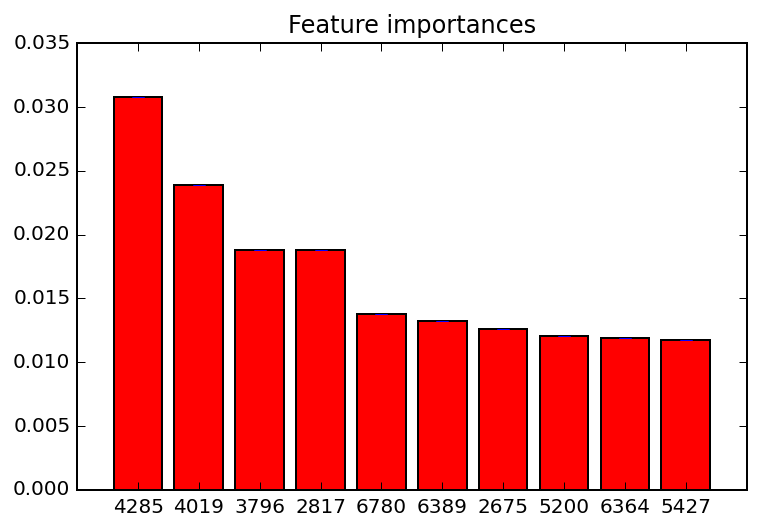

In [32]:
#top 10 indices:
indices = np.argsort(importances)[::-1][0:10]
feature_names = vectorizer.get_feature_names()
print ("top10words : ")
for i in range(10):
    print (indices[i],feature_names[indices[i]])
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(10), indices)
plt.xlim([-1, 10])
plt.show()

## Further Improvements
- Study the numbers in the features, compare the results after removing the numbers.
- Study the wrongly classfied messages for further insights.

## Reference
- confusion matrix http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
- classification table https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report?noredirect=1&lq=1
- plot feature importance http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html